## TO DO:
* clean feature variables
    * which ones are we keeping/ creating?
    * numeric features? categorical features?
* MO MODELS
    * predict on specific violations
    * recent admission forecast
* presentaton

## Lit review
Similar projects used:
* OLS
* Deep Learning
    * Gradient based networks
    

In [1]:
# some tehcnicalities for working on the campus computers
import os

import sys
sys.path.append(r'R:/JoePriceResearch/Python/Anaconda3/Lib/site-packages')

In [41]:
import itertools
import operator
import re

import pandas as pd # getting the data
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

seed = 17

In [3]:
df = pd.read_csv('ICPSR_04572/DS0001/04572-0001-Data.tsv', sep='\t')
df2 = pd.read_csv('ICPSR_04572/DS0002/04572-0002-Data.tsv', sep='\t')
print('first part shape:',df.shape)
print('second part shape:',df2.shape)
print(all(df2.columns == df.columns))
df = df.append(df2)
print('all together shape:',df.shape)
df.head()

first part shape: (3686, 3374)
second part shape: (14499, 3374)
True
all together shape: (18185, 3374)


,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,V0010,...,CS_INCDA,CS_INCJ,CS_INCA,CH_NUMCAR,CH_NUMCAR1,CH_NUMCAR2,CH_NUMCAR3,CH_NUMCAR4,CH_NUMCAR5,CH_CRIM_HISTORY
0,15717,10,201,2,2,0,5,10,215,99,...,0,0,0,0,1,1,1,1,1,2
1,15718,10,201,2,2,0,5,8,310,99,...,0,0,0,0,1,1,1,1,1,2
2,15719,10,201,2,2,0,5,2,145,99,...,0,0,0,0,1,1,1,1,1,2
3,15720,10,201,2,2,0,5,6,150,99,...,0,0,0,0,1,1,1,1,1,2
4,15721,10,201,2,2,0,4,11,183,99,...,0,0,1,1,2,1,2,2,2,1


## Feature cleaning and Engineering

In [4]:
# all of these values are missing data so we will replace them with np.nan
nan_list = [99, 999, 9999, 9999.99, 99999, 99999.99, 999999, 999999.99,9999999,9999999.99,
            99999999, 99999999.99, 9999999.98,9999998.00, 9999999.98, 9999998.00, 9999997.00]
df.replace(nan_list, np.nan, inplace=True)

We need to clean up some variables that we will be using as outcomes and things that come as a direct result like disciplinary action

In [5]:
# this block has the violations and discipline
discipline_cols = [f'V{i}' for i in range(2500, 2565)]
discipline = df[discipline_cols]
df.drop(columns=discipline_cols, inplace=True)

In [6]:
# renaming target variables
targets = {# 'v2517':'breaking_rules', ### FIXME: This one isn't working for some reason
'V2518':'drugs',
'V2519':'n_drugs',
'V2520':'alcohol',
'V2521':'n_alcohol',
'V2522':'weapon_poss',
'V2523':'n_reapon_poss',
'V2524':'stolen_prop',
'V2525':'n_stolen_prop',
'V2526':'poss_unauth',
'V2527':'n_poss_unauth',
'V2528':'verbal_staff',
'V2527':'n_verbal_staff',
'V2530':'phys_staff',
'V2531':'n_phys_staff',
'V2532':'verb_inmate',
'V2533':'n_verb_inmate',
'V2534':'phys_inmate',
'V2535':'n_phys_inmate',
'V2536':'att_escape',
'V2537':'n_att_escape',
'V2538':'out_place',
'V2539':'n_out_place',
'V2540':'disobey_ord',
'V2541':'n_disobey_ord',
'V2542':'maj_violation',
'V2543':'n_maj_violation',
'V2544':'minor_violation',
'V2545':'n_minor_violation',
'V2546':'other_violation',
'V2547':'n_other_violation',
'V2549':'recent_violations',
}
discipline.rename(mapper=targets, axis='columns', inplace=True)

/Users/branchflower/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [7]:
# we only need to rename these ones for now and we will work with the other ones if we see a particular importance
varnames = {'V0001':'id','V00014':'age','V0019':'hispanic','V0037':'white','V0038':'black',
            'V0039':'native_american','V0040':'asian','V0041':'pacfic_islander',
            'V0042':'other_race','V0043':'unknown_race','V0046':'born_us',
            'V0058':'marital_status','V0059':'military_service','V0079':'time_mil_service',
            'V0083':'corrently_sentenced','V0084':'crim_stat_arrest','V0085':'wait_judicial_res',
            'V0086':'wait_trial','V0087':'wait_parole','V0088':'judge_informed_time',
            'V0089':'crim_stat_last_arrest','V0090':'held_other_authorities','V0091':'held_safekeeping',
            'V0092':'held_other_reason',
            # use offense codes for replacement to get categories of crimes
                # 94,96,98,100,102 previous holding offenses
                # 95,97,999,101,103 number of charges for said offenses
                # 115,117,119,121,123 current holding offenses
                # 116,118,120,122,124
            'V0125':'arrest_month','V0127':'arrest_year',
            'V0638':'crim_just_status',
            # 639 - : pleas and trial info
           }
df.rename(mapper=varnames, axis='columns', inplace=True)


In [8]:
# create height variable
df['height'] = [(x * 12) if x < 90 else np.nan for x in df['V0007']]
df['V0008'] = [y if y < 97 else 0 for y in df['V0008']]
df['height'] = [x + y if y < 13 else y for x, y in zip(df['height'], df['V0008'])]

In [9]:
# create binary plea or guilty verdict variable
df['plea'] = df['V0639'].replace(99,np.nan).fillna(df['V0640'].replace([99,2],[np.nan,1])).fillna(df['V0641'].replace([99,3],[np.nan,1])).fillna(df['V0642'].replace([99,4],[np.nan,1])).fillna(df['V0643'].replace([99,5],[np.nan,1]))
df['found_guilty'] = df['V0647'].replace([2,7,8,9],[0,np.nan,np.nan,np.nan])

In [10]:
# generate time since arrest variables
df['mth_int_arr'] = (df['V2955'].replace(9999, np.nan) - df['V2953'].replace(9999,np.nan)) * 12 + (df['V2956'].replace(9999,np.nan) - df['V2952'].replace(9999, np.nan))
df['mth_int_arr'][df['mth_int_arr'] < 0] = np.nan

/Users/branchflower/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# Many values are codes as 1 and 2 for yes and no respectively we will change 2s to 0s
two_to_zero = ['SES_PARENTS_INCARCERATED','SES_FAMILY_INCARCERATED', 'DRUG_ANY', 'DRUG_COCRK','DRUG_HEROPIT',
 'DRUG_DEPRES',
 'DRUG_STIMU','DRUG_HALLU', 'DRUG_MARIJ', 'DRUG_INHAL', 'DRUG_METHAM', 'DRUG_COCRK', 'DRUG_DEPREG',
 'DRUG_STIMREG','DRUG_HALUREG', 'DRUG_MARIJREG', 'DRUG_INHALREG', 'DRUG_METHAMREG','DRUG_ANYMTH', 'DRUG_COCRKREG',
 'DRUG_DEPMTH','DRUG_STIMMTH','DRUG_HALUMTH', 'DRUG_MARIJMTH', 'DRUG_INHALMTH', 'DRUG_METHAMTH',
 'DRUG_ANYTME', 'DRUG_COCRKTME','DRUG_HROPTME', 'DRUG_DEPTME', 'DRUG_STIMTME','DRUG_HALUTME', 'DRUG_MARIJTME',
 'DRUG_METHATME', 'DRUG_NUMPOS_CAGE', 'DRUG_ANY_ALCDRUGTME', 'DRUG_DROVE_ALCDRUG', 'DRUG_CARACCIDENT_ALCDRUG', 
 'DRUG_DISPUTES_ALCDRUG', 'DRUG_FIRED_ALCDRUG', 'DRUG_WORKTROUBLE_ALCDRUG', 'DRUG_ARRESTED_ALCDRUG',
 'DRUG_FIGHT_ALCDRUG', 'DRUG_ANYTRT', 'DRUG_ANYPGM', 'DRUG_HEROIN_CB', 'DRUG_OPIATES_CB', 'DRUG_METHAMP_CB',
 'DRUG_AMPH_CB','DRUG_METHAQ_CB','DRUG_BARB_CB','DRUG_TRANQ_CB', 'DRUG_CRACK_CB','DRUG_COCAINE_CB',
 'DRUG_PCP_CB', 'DRUG_HALLU_CB', 'DRUG_MARIJ_CB', 'DRUG_OTHERDRUG_CB', 'DRUG_INHAL_CB', 'DRUG_INJECT_CB',
 'DRUG_HEROINREG_CB', 'DRUG_OPIATESREG_CB', 'DRUG_METHAMPREG_CB',
 'DRUG_AMPHREG_CB','DRUG_METHAQREG_CB','DRUG_BARBREG_CB','DRUG_TRANQREG_CB', 'DRUG_CRACKREG_CB','DRUG_COCREG_CB',
 'DRUG_PCPREG_CB', 'DRUG_HALLUREG_CB', 'DRUG_MARIJREG_CB', 'DRUG_OTHERDRUGREG_CB', 'DRUG_INHALREG_CB',
 'DRUG_HEROINMTH_CB', 'DRUG_OPIATESMTH_CB', 'DRUG_METHAMPMTH_CB',
 'DRUG_AMPHMTH_CB','DRUG_METHAQMTH_CB','DRUG_BARBMTH_CB','DRUG_TRANQMTH_CB', 'DRUG_CRACKMTH_CB','DRUG_COCAINEMTH_CB',
 'DRUG_PCPMTH_CB', 'DRUG_HALLUMTH_CB', 'DRUG_MARIJMTH_CB', 'DRUG_OTHERDRUGMTH_CB', 'DRUG_INHALMTH_CB',
 'DRUG_ANYINF_CB', 'DRUG_CURRENTOFFENSE_DRUGS', 'DRUG_DROVE_DRUG', 'DRUG_CARACCIDENT_DRUG', 'DRUG_DISPUTES_DRUG',
 'DRUG_TRT', 'CITIZENSHIP', 'CO_PAROLEVIOLATION', 'CO_PROBVIOLATION', 'CO_NEWCOURTCOMMIT', 'CO_UNSENTENCED',
 'IC_ONEVICT_HISPANIC', 'IC_ONEVICT_GENDER', 'IC_MANYVICT_INCIDENT', 'IC_MANYVICT_HISPANIC', 'IC_MANYVICT_KNOWNVICT',
 'GENDER','SEX_OFFENDER', 'MCMH_SMI', 'SES_PARENTS_MINOR', 'SES_LIVE_CHILDREN', 'SES_LIVE_CHILD_ARREST',
 'SES_ANY_CHILDREN', 'CS_SEX_TREATMENT', 'CH_CRIM_HISTORY', 'MCMH_MENTAL_HISTORY']
two_to_zero.extend([x for x in df.columns if re.search(r'DRUG_.+?_TMEINF',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'SES_INCOMES.+?[^M]',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'IC_W.+?',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'MCMH_\w$',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'MCMH_MH_.+?$',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'MCMH_WHEN_.+?$',x)])
two_to_zero.extend([x for x in df.columns if re.search(r'MCMH.*?HIV.*?',x)])
# do the actual change

for c in two_to_zero:
    df[c] = df[c].replace(2, 0)
    df[c] = df[c].replace([7,8,9], np.nan)

In [14]:
# variables that should be categorical but are numeric
to_cat = ['RACE','SES_AGEPERP_PHYSSEXABUSED','SES_OFF_RAPED','SES_PERP_SEX_KNOWN','CH_CRIMHIST_COLLAPSED', 'CH_PRIORSENTENCE',
'CO_STATUSTME', 'SES_LIVEDGROWINGUP','DRUG_NUMPOS_CAGE_COLLAPSED','DRUG_ALCYEAR_FREQ','CO_CURRENTOFFENSE',
'SES_INCOMEMTH', 'IC_ONEVICT_RACE', 'IC_ONEVICT_AGECAT', 'IC_ONEVICT_RELATIONSHIP', 'IC_MANYVICT_RACE',
 'IC_MANYVICT_GENDER', 'DRUG_HIERARCHY2','TYPEOFFENSE','MOST_SERIOUS_OFFENSE2', 'MCMH_EVERRPT']

# do the actual change
for c in to_cat:
    df[c] = df[c].astype(str)

In [15]:
# special encoding for sentence length
# 1000 is life
df['life_sentence'] = df['CS_SENTENCEMTH'] == 10000
df.loc[df['CS_SENTENCEMTH'] > 720,'CS_SENTENCEMTH'] = 720

In [17]:
# named variables to drop
drop_me = ['SES_PERP_SEX_FAMILY','SES_PERP_SEX_PARENT', 'SES_PERP_SEX_RELATIVE','SES_PERP_SEX_SPOUSE',
 'SES_PERP_SEX_SPOUSE_BOY_GIRL','SES_PERP_SEX_BOY_GIRL','SES_PERP_SEX_FRIEND','SES_PERP_SEX_OTHER',
'CH_CRIMHIST', 'CH_PROBATION','CH_INCARCERATION','SES_MINOR_ADULT_CHILDREN', 'DRUG_TRTINC',
 'DRUG_TRTPRB', 'DRUG_TRTCORR', 'DRUG_TRT_ALC_PROBPAR', 'DRUG_TRT_DRUG_PROBPAR', 'DRUG_TRT_ADM',
 'DRUG_TRT_ALC_ADM', 'DRUG_TRT_DRUG_ADM', 'DRUG_PGMINC', 'DRUG_PGMPRB','DRUG_PGMCORR', 'DRUG_PGMPRBALC',
 'DRUG_PGMPRBDRUG', 'DRUG_PGMADM', 'DRUG_PGMADMALC', 'DRUG_PGMADMDRUG', 'DRUG_TRPINC', 'DRUG_TRPPRB',
 'DRUG_TRPCORR', 'DRUG_TRPPRBALC', 'DRUG_TRPADM', 'DRUG_TRPADMALC', 'DRUG_TRPADMDRUG',
 'DRUG_FIRED_DRUG', 'DRUG_WORKTROUBLE_DRUG', 'DRUG_ARRESTED_DRUG', 'DRUG_FIGHT_DRUG', 'DRUG_12DRINKS', 
 'DRUG_ALCREG', 'DRUG_ALCYEAR', 'DRUG_ALCTME', 'DRUG_CUTDOWN_ALC', 'DRUG_CRITICISM_ALC', 'DRUG_GUILITY_ALC', 
 'DRUG_FIRSTTHING_ALC', 'DRUG_DRIVE_ALC', 'DRUG_ACCIDENT_ALC', 'DRUG_5LIQUOR_EQ_ALC','DRUG_DISPUTE_ALC',
 'DRUG_LOSTJOB_ALC', 'DRUG_WORKTROUBLE_ALC', 'DRUG_ARRESTED_ALC', 'DRUG_FIGHT_ALC', 'DRUG_TRT_DETOX',
 'DRUG_TRT_RES', 'DRUG_TRT_PROFCOUN', 'DRUG_TRT_GROUP', 'DRUG_TRT_EDUCPRG', 'DRUG_TRT_MAINDRUG', 
 'DRUG_TRT_OTHERPRG', 'DRUG_TRT_SEPPRG','IC_ONEVICT_KNOWNVICTWELL','IC_ONEVICT_KNOWNVICT',
 'IC_MANYVICT_HISPANIC_OVERALL', 'IC_MANYVICT_SAMERACE', 'IC_MANYVICT_YOUNGEST', 'IC_MANYVICT_OLDEST',
 'CAT_AGE3', 'DRUG_HIERARCHY','MOST_SERIOUS_OFFENSE1','MCMH_MHOSPYR', 'MCMH_MHOSPADM', 'MCMH_MHOSPYRADM']
drop_me.extend([x for x in df.columns if re.search(r'DRUG.*?TRT.*?_INC',x)])
drop_me.extend([x for x in df.columns if re.search(r'DRUG.*?TRT_.+?_PROBPAR',x)])
drop_me.extend([x for x in df.columns if re.search(r'DRUG.*?TRT_.+?_ADM',x)])
drop_me.extend([x for x in df.columns if re.search(r'SES_PERP_PHYS_[^K].+?',x)])
drop_me.extend([x for x in df.columns if re.search(r'SES_PERP_PHYSSEX.*?',x)])
drop_me.extend([x for x in df.columns if re.search(r'SES_INCOME[^M].*?MTH',x)])
drop_me.extend([x for x in df.columns if re.search(r'IC_MANYVICT_[^K].*?',x)])
drop_me.extend([x for x in df.columns if re.search(r'CH_NUMCAR\d',x)])
# do the actual dropping
df.drop(columns=drop_me, inplace=True)

In [18]:
# these are some more variables that we will not use as the info in the codebook says they are redundant
drop_list = [3,4,6,10,11,12,13,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,44,45,47,48,
49,50,51,52,53,54,55,56,57,60,61,62,63,64,65,66,67,68,69,70,71,71,72,73,74,75,76,77,78,80,81,
82, 639,640,641,642,643]
more_drops = [x for x in range(150,638)]
drop_list.extend(more_drops)
more_drops = [x for x in range(2622,2928)]
drop_list.extend(more_drops)
more_drops = [x for x in range(2603,2620)]
drop_list.extend(more_drops)
more_drops = [x for x in range(2959,2969)]
drop_list.extend(more_drops)
more_drops = [x for x in range(2955,2958)]
drop_list.extend(more_drops)
df.drop(["V{:04}".format(x) for x in drop_list], axis='columns')
# 20-26 clarify hispaninc origin
# 51,52 has citizenship info but too much was missing to be worth using
# 60 - 66 clarify military service
# 82 has discharge type for military
# 104 - 114 previous arrest dates too many missing to be useful
# 123-149 time of arrest, admission and release variables
# 150 - 637 previous prison sentences undr other circumstances like parole violations and such
    # 150-166 parole revocation info
    # 167-190 parole readmission and release info
# 559 days spent escaped

print(f'Down to {df.shape[1]} columns')

Down to 3157 columns


In [19]:
# classify types of offenses 'V{}'.format(, '')
offense_codes = {'homicide':[10,11,12,13,14],
 'manslaughter':[15,16,20,21,22,30,31,32],
 'kidnapping':[40,41,42],
 'rape':[50,51,52,60,61,62],
 'sexual assault':[70,71,72,80,81,82],
 'armed robbery':[90,91,92],
 'unarmed robbery':[100,101,102],
 'sodomy':[110,111,112],
 'assault':[120,121,122,130,131,132,140,141,142],
 'extortion':[150,151,152],
 'hit and run':[160,161,612,300],
 'child abuse':[170,171,172],
 'other violence':[180],
 'burglary':[190,191,192],
 'arson':[200,201,202],
 'auto theft':[210,211,212],
 'fraud, embezzlement, bribery':[220,221,222,260,261,262,673,674,675,800,810,820,830,860],
 'larceny':[230,231,232,240,241,242,250,251,252],
 'trafficking stolen property':[270,271,272,280,281,282],
 'destruction of property':[290,291,292],
 'unauthorized vehicle':[310,311,312],
 'trespassing':[320,321,322],
 'other property offense':[330,331,332],
 'drug trafficking':[340,341,342,350,351,352,360,361,362,370,371,372],
 'drog posession/use':[380,381,382,385,286,387,390,391,392,400,401,402,410,420,425,430,440,450],
 'escape':[460,461,462,470,471,472],
 'weapon offense':[480,481,482],
 'parole/probation violation':[490,500],
 'rioting':[510,511,512],
 'habitual':[520],
 'other':[530,580,630,650,670,671,672,660,690,691,692,700,710,840,880,870],
 'court offense':[540,541,542],
 'traffic violations':[550,560,565,570],
 'decency offenses':[590,600],
 'immigration':[610],
 'obstruction of law':[620,621,622],
 'vice':[640],
 'juvenile':[680],
 'tax':[850]
                }

occupation_codes = {
    'managerial position':[1,2,4,5,10,11,12,13,14,15,16,20,21,22,23,30,
                           31,32,33,34,35,36,40,41,42,43],
    'business operations':[50,52,53,54,56,60,62,70,71,72,73,80,81,82,83,
                           84,85,86,91,93,94,95],
    'CS and Math':[100,101,102,104,106,110,111,122],
    'Architecture and engineering':[130,131,134,136,140,141,142,143,146,
                                    153,154,155,156],
    'life,physical,social science':[160,172,174,176,181,182,186,192,193,196],
    'community and social services':[200,201,202,204,206],
    'legal':[210,211,214,215],
    'education':[220,230,232,233,234,240,243,244,254,255],
    'enetertainment':[160,263,270,271,272,274,275,276,280,282,283,285,286,290,291,292],
    'health':[303,305,306,313,316,324,325,330,332,340,341,350,351,352,353,354,
    360,361,362,363,364,365],
    'protective services':[370,371,372,373,374,380,382,385,390,391,392,394,395],
    'food prep':[400,401,402,403,404,405,406,411,412,413,414,415,416],
    'maintenance':[420,421,422,423,424,425,700,701,702,703,704,710,711,712,713,714,715,
    716,720,721,722,724,726,731,732,733,734,735,736,741,742,743,751,752,
    754,755,756,760,761,762],
    'personal care and service':[430,432,434,435,440,442,443,446,450,451,
                                 452,453,454,455,460,461,462,464,465],
    'sales':[470,471,472,474,475,476,480,481,482,483,484,485,490,492,494,495,496],
    'administrative support':[500,501,502,503,510,511,512,513,514,516,520,522,523,524,526,530,532,
    532,533,535,536,540,541,542,551,552,553,554,555,556,560,561,562,563,
    570,580,581,582,583,584,585,586,590,591,593],
    'farm fish forest':[600,601,602,604,605,610,612,613],
    'construction':[620,621,622,623,624,625,626,630,631,632,633,635,636,640,642,643,644,
    646,650,651,652,653,660,666,670,671,672,673,674,675,676,680,682,683,684,
    692,693,694],
    'production':[770,771,772,773,774,775,780,781,783,784,785,790,792,793,795,796,
    800,801,802,803,804,810,813,814,815,816,820,821,822,823,824,825,826,
    830,831,832,833,834,835,840,841,842,845,846,850,851,952,853,854,855,
    860,861,862,863,864,865,871,872,873,874,875,876,880,881,883,890,891,
    892,893,895,896],
    'transportation':[900,903,904,911,912,913,914,915,920,923,924,926,930,931,933,935,936,
    941,942,951,952,956,960,961,962,963,964,965,972,974,975],
    'military':[980,981,982,983]
}

In [20]:
offense_vars = [94,96,98,100,102,115,117,119,121,123]
for c in ["V{:04}".format(x) for x in offense_vars]:
    for x, y in offense_codes.items():
        df[c] = df[c].replace(y, x)

In [21]:
df.rename({'V1776':'OCCUPATION'}, axis='columns', inplace=True)
for x, y in occupation_codes.items():
        df['OCCUPATION'] = df['OCCUPATION'].replace(y, x)

In [22]:
for c in ['V1057', 'V1061']:
    df[c] = df[c].replace(['97','98','99'], np.nan)
df.dropna(axis='columns', how='all', inplace=True)
df.shape

(18185, 2991)

## Target

In [23]:
y = discipline.loc[:,targets.values()]
y.rename(mapper=targets, axis='columns', inplace=True)

In [24]:
y_cat = discipline.loc[:,[c for c in targets.values() if not re.search(r'^n_.*', c) and not c == 'recent_violations']]

In [25]:
y_num = discipline.loc[:,[c for c in targets.values() if re.search(r'^n_.*', c) or c == 'recent_violations']]

In [26]:
for c in y_num.columns:
    y_num[c] = y_num[c].replace([97,98,99],np.nan)
for c in y_cat.columns:
    y_cat[c] = y_cat[c].replace([9,8,7,2],[np.nan,np.nan,np.nan,0])
y_cat.head()
violator = y_cat.fillna(0).max(axis='columns')
violator.value_counts()

0.0    10035
1.0     8150
dtype: int64

In [46]:
y_cat.columns

Index(['drugs', 'alcohol', 'weapon_poss', 'stolen_prop', 'poss_unauth',
       'verbal_staff', 'phys_staff', 'verb_inmate', 'phys_inmate',
       'att_escape', 'out_place', 'disobey_ord', 'maj_violation',
       'minor_violation', 'other_violation'],
      dtype='object')

Our targets will be drug violations, assault on staff, assault on inmates, attempt to escape, other violations and the most recent violation.

We have an incredible number of possible features that ar enot named. to save on cleaning time we will look at the most ocrrelated potential features and work on cleaning those so we don;t spend time on variables that we will not use. 
* correlation with preprison sentencing and custody level in prison
* violations and levels of custody
* correlations between punishments and violations
* look at jail composition and the nature of violations



## Modelling

In [27]:
# preprocessing
from sklearn.model_selection import train_test_split

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import lightgbm as lgb

# assessment
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

/Users/branchflower/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [37]:
# CREDIT: SCIKIT LEARN DOCUMENTATION at https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# feature selection
* find some variables that we think would be particualrly important
* look for what the data tells us is important
* use a combination of the 2 to determine which variables

Just throwing it in a random forest and seeing what happens, we can use the importances 

In [28]:
# this is will just be using the named variables as we filtered through and named the ones that weren't alreayd
named_cols = [c for c in df.columns if not re.search(r'^V\d{4}', c)]
named = df[named_cols]
named.shape

(18185, 265)

In [30]:
# we spent much time accounting for the missing values in the analysis variables so we feel comfortable 
# filling in a 0 here. We dropped the other ones where another value would be more appropriate
named_train, named_test, violator_train, violator_test = train_test_split(pd.get_dummies(named.fillna(0)),
                                                                          violator.fillna(0), random_state=seed) # y_cat['alcohol']

In [31]:
named_rf = RandomForestClassifier(n_estimators=10000, criterion='gini', max_depth=20,
                            bootstrap=True, max_features=50,
                            verbose=1, n_jobs=-1, random_state=seed)

In [32]:
# using just the named columns
named_rf.fit(pd.get_dummies(named_train.fillna(0)),violator_train.fillna(0))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=50, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=17, verbose=1, warm_start=False)

In [33]:
named_sorted_x = sorted({x:y for x, y in zip(named.columns, named_rf.feature_importances_)}.items(), key=operator.itemgetter(1))
for x, y in named_sorted_x[:100:-1]:
    print(x, ':', y)

CH_CRIMHIST_COLLAPSED : 0.057081982485460946
MCMH_WHEN_DISORDER : 0.047399310538364485
SES_OFF_RAPED : 0.04247420424993857
id : 0.04156988978705501
SES_PERP_SEX_KNOWN : 0.024341854689360926
DRUG_AMPH_TMEINF : 0.019596305404387615
MCMH_MH_DRUGS_ARREST : 0.017605306813937908
CO_CURRENTOFFENSE : 0.01557090124427095
DRUG_BARB_TMEINF : 0.015177274151860322
arrest_month : 0.011905683843795726
VETERAN : 0.01119614951321341
CO_NEWCOURTCOMMIT : 0.010934221797344663
marital_status : 0.010306043698735732
CH_INCARCERATION_NUM : 0.009155077873105927
DRUG_METHAMP_TMEINF : 0.008764403356192657
SES_PHYSSEXABUSED_EVER : 0.00809376900366006
MCMH_MH_TREATMENT_AD : 0.007927180671802973
AGE_CAT : 0.007898745360620586
SES_AGEOFF_PHYSSEXABUSED : 0.007614922532052187
crim_just_status : 0.0075012467049444
MCMH_MH_TREATMENT_PA : 0.0066868662165895515
CO_STATUSTME : 0.006378971293826985
SES_AGEPERP_PHYSSEXABUSED : 0.006194414267561142
DRUG_OPIATESMTH_CB : 0.004952220056464139
DRUG_MARIJREG : 0.004948521531765772

We used this list to determine which variables to use and which ones might be worth looking deeper into

The fact that time served is the most important means that we aren't really doing a good job of identifying the characteristics that make someone a violator of prison rules. finding some way to get around the fact that people simply break rules if they have been in prison longer would be important
maybe ration of violation nuber to time served oir subsetting the data to those recently entered into prison.

In [34]:
print(f1_score(y_true=violator_train.fillna(0),
      y_pred=named_rf.predict(pd.get_dummies(named_train).fillna(0))))
print(f1_score(violator_test.fillna(0), named_rf.predict(pd.get_dummies(named_test).fillna(0))))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed:   11.0s
[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:

0.9991858003582478


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed:    4.0s


0.6569536423841059


[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:    4.7s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:

Confusion matrix, without normalization
[[2012  531]
 [ 764 1240]]


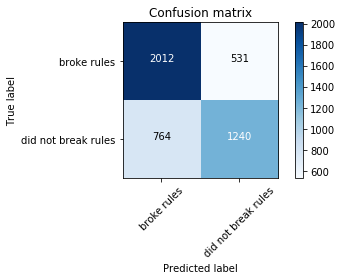

In [42]:
plot_confusion_matrix(confusion_matrix(violator_test.fillna(0),
                                       named_rf.predict(pd.get_dummies(named_test).fillna(0))),
                     ['broke rules', 'did not break rules'])

In [ ]:
logit = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1500).fit(np.array(pd.get_dummies(X).fillna(0), dtype='float64'), violator)
logit.fit(named_train)
logit.predict(pd.get_dummies(X).fillna(0))

In [ ]:
# this is a function to repeat the process with the different types of violations
